In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import math

In [2]:
city = 'chicago'

In [3]:
#create a dic where the key is the city name and the value is the bounding box
city_bound = {'newberg':[-122.98861694,45.28316879,-122.92491913,45.33226395],'chicago':[-88.15451813,41.55007553,-87.58644104,42.09182739]}

In [4]:
df = pd.read_csv('../../../data/shared/labels-with-tags-chu.csv')

In [5]:
#select city == current city
df = df[df['city'] == city]
df

,city,label_id,label_type,severity,zoom,heading,pitch,photographer_heading,photographer_pitch,user_id,global_attribute_id,tag_list,description,lat,lng
344616,chicago,8,CurbRamp,2.0,2,136.687500,-18.625000,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,734342.0,points into traffic,NaN,42.083668,-87.980347
344617,chicago,9,CurbRamp,1.0,2,249.937500,-14.125000,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,734065.0,NaN,NaN,42.083694,-87.980606
344618,chicago,10,CurbRamp,2.0,3,288.656250,-13.187500,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,NaN,missing tactile warning,NaN,42.083786,-87.980606
344619,chicago,11,CurbRamp,3.0,3,49.245537,-16.220982,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,733678.0,"narrow,points into traffic",NaN,42.083794,-87.980354
344620,chicago,12,CurbRamp,3.0,3,42.636162,-16.033482,268.225098,-0.562027,3e25ea1d-f762-421a-b98b-3cba36e1bbfb,733921.0,"missing tactile warning,steep",NaN,42.083817,-87.980362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368549,chicago,22167,Occlusion,NaN,3,198.160721,-5.162946,270.809662,0.730950,325198df-cddc-44ee-a87e-c831c3147aa0,NaN,NaN,NaN,41.953518,-87.730461
368550,chicago,22168,Occlusion,NaN,3,198.160721,-5.162946,270.893951,0.790565,325198df-cddc-44ee-a87e-c831c3147aa0,NaN,NaN,NaN,41.953514,-87.730324
368551,chicago,22169,Occlusion,NaN,3,198.160721,-5.162946,270.677826,0.706790,325198df-cddc-44ee-a87e-c831c3147aa0,NaN,NaN,NaN,41.953518,-87.730240
368552,chicago,22170,Occlusion,NaN,3,214.448654,-3.897321,268.717926,0.749344,325198df-cddc-44ee-a87e-c831c3147aa0,NaN,NaN,NaN,41.953522,-87.730850


In [7]:
#get Nan counts of global attribute id
df['global_attribute_id'].isna().sum()

4590

In [8]:
#turn df into geodataframe
geometry = [Point(xy) for xy in zip(df.lng, df.lat)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

<AxesSubplot: >

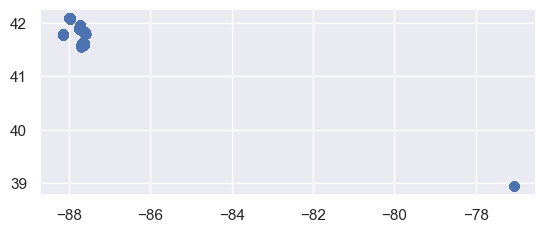

In [9]:
gdf.plot()

In [10]:
#fix the geometry to the city bound
o_input = gdf.cx[city_bound[city][0]:city_bound[city][2], city_bound[city][1]:city_bound[city][3]]


In [11]:
#select only label id taglist and description 
o_input = o_input[['label_id', 'tag_list', 'description']]

In [13]:
#select only label id taglist and description 
o_input = o_input[['label_id', 'tag_list', 'description']]

In [14]:
#select tag list that are not nan
tag = o_input.drop(columns=['description'])
tag = tag[tag['tag_list'].notna()]
# create a new column with the length of the tag list 
tag['tag_count'] = tag['tag_list'].str.split(',').str.len()
#drop tag_list column
tag = tag.drop(columns=['tag_list'])

In [15]:
#merge with o_input
o_input = o_input.merge(tag, on='label_id', how='left')

In [16]:
# #turn nan to 0 non nan to 1
o_input['tag_list'] = o_input['tag_list'].notna().astype('int')
o_input['description'] = o_input['description'].notna().astype('int')
#fill nan with 0
o_input = o_input.fillna(0)


In [17]:
#group by label id and keep max
o_input= o_input.groupby('label_id').max()
#reset index
o_input = o_input.reset_index()

In [18]:
o_input

,label_id,tag_list,description,tag_count
0,8,1,0,1.0
1,9,0,0,0.0
2,10,1,0,1.0
3,11,1,0,2.0
4,12,1,0,2.0
...,...,...,...,...
18892,22167,0,0,0.0
18893,22168,0,0,0.0
18894,22169,0,0,0.0
18895,22170,0,0,0.0


In [19]:
#read in the raw labels
labels = pd.read_csv('../../../data/{}/processed-labels/labels_raw_{}.csv'.format(city, city))

In [20]:
#create a new df with only label id from labels
label_ids = labels[['label_id']]
#merge label ids with o_input
o_input = pd.merge(label_ids, o_input, on='label_id', how='left')
#fill nan with 0
o_input = o_input.fillna(0).sort_values(by='label_id').reset_index(drop=True)
o_input

,label_id,tag_list,description,tag_count
0,8,1.0,0.0,1.0
1,9,0.0,0.0,0.0
2,10,1.0,0.0,1.0
3,11,1.0,0.0,2.0
4,12,1.0,0.0,2.0
...,...,...,...,...
18280,21507,1.0,0.0,1.0
18281,21508,1.0,0.0,1.0
18282,21509,0.0,0.0,0.0
18283,21517,0.0,0.0,0.0


In [21]:
#rename columns tag_list to tags
o_input.rename(columns={'tag_list':'tag'}, inplace=True)
#change the order of columns to label_id, tags, tags_count, description
o_input= o_input[['label_id', 'tag', 'tag_count', 'description']]

In [22]:
#export to csv 
o_input.to_csv('../../../data/{}/features/optional_input.csv'.format(city), index=False)